<table style="width: 100%;">
  <tr>
    <td style="text-align: left;"><h1 style="font-size: 30px;">SVM, Logistic Regression, Decision Tree and Ranodom Forest Code</h1></td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>

## Model making

### Imports

In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm #Visualising exectuion progress

#for printing preatty
from markdown import markdown
from IPython.display import Markdown, HTML
from rich import print

# Eliminate warnings for presentation purpuses
import warnings
warnings.filterwarnings('ignore') #ignore all warnings, very messy
#warnings.filterwarnings('default')
pd.options.mode.chained_assignment = None

#To be able to show matplotlib graphs and results in this JupyterNotebook
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# Load the database using the second row as the name of the features
df=pd.read_excel(r'credit_cards.xls',engine='xlrd',header=1)

X=df.drop('default payment next month',axis=1)
y=df['default payment next month']


In [3]:
print(f"This is a snippet of the database being used")
display(df.head())

This is a snippet of the database being used

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score,confusion_matrix, recall_score,f1_score,brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from hmeasure import h_score

### Model

In [5]:
scaler=StandardScaler()

In [6]:
# --------------------------------------------------------

# FIT THE MODEL AND EXTRACT NEW RESULTS

# --------------------------------------------------------
def get_scores(classifier,X_train, X_test,y_train,y_test):
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    y_pred1=classifier.predict_proba(X_test)
    accuracy=accuracy_score(y_test,y_pred).round(2)
    auroc=roc_auc_score(y_test,y_pred)
    conf=confusion_matrix(y_test,y_pred)
    precision=precision_score(y_test,y_pred,pos_label=0)
    recall=recall_score(y_test,y_pred,pos_label=0)
    h=h_score(np.array(y_test),y_pred,pos_label=0)
    f1=f1_score(y_test,y_pred,pos_label=0)
    bs=brier_score_loss(y_test,y_pred1[:,0],pos_label=0)
    return accuracy,auroc,conf,precision,recall,f1,h,bs


In [7]:
# --------------------------------------------------------

# TRAIN THE MODEL AND EXTRACT RESULTS

# --------------------------------------------------------
def train_new_model(model,X,y,name = ""):
    
    accuracy, auroc, precision, recall, f1, h, bs = [[] for _ in range(7)]
    conf=np.zeros([2,2])
    kfolds=10
    skf=StratifiedKFold(n_splits=kfolds)

    for train_index, test_index in tqdm(skf.split(X, y)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaled_X_train=scaler.fit_transform(X_train)
        scaled_X_test=scaler.transform(X_test)
        
        # New Scores
        
        scores = get_scores(model,scaled_X_train, scaled_X_test,y_train,y_test)

        accuracy.append(scores[0])
        auroc.append(scores[1])
        conf += scores[2]
        precision.append(scores[3])
        recall.append(scores[4])
        f1.append(scores[5])
        h.append(scores[6])
        bs.append(scores[7])

    print(f"___________Model {name} fitted")
    
    dict_results = {"accuracy":accuracy,"auroc":auroc, "conf":conf, "precision":precision,
                   "recall":recall, "f1":f1,"h":h,"bs":bs, "kfolds":kfolds}
    
    return model, dict_results

In [8]:
def train_all_models():
    # Decision tree lists
    c_dt,dt_dict  = train_new_model(c_dt,X,y,"Decision Tree")
    c_lr,lr_dict  = train_new_model(c_lr,X,y,"Logistic Regresion")
    c_rf,rf_dict  = train_new_model(c_rf,X,y,"Random Forest")
    svm, svm_dict = train_new_model(svm,X,y,"Support Vector Machine")
    print(f"___________All Models fitted")
    
    return c_dt,dt_dict,c_lr,lr_dict,c_rf,rf_dict,svm, svm_dict

In [9]:
# --------------------------------------------------------

# THESE FUNCTIONS WILL HELP US SAVE AND LOAD MODELS AND RESULTS

# --------------------------------------------------------
import pickle
import os
import json
        
def save_results(data,name = "results_full_knn", algo = 'KNN'):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{algo}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, fr'{name}.json')
    
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)
        
def load_results(name = "results_full_knn", algo = 'KNN'):
    doc_name = fr'models/{algo}/{name}.json'
    with open(doc_name, 'rb') as pickle_file:
        results = pickle.load(pickle_file)
    return results

def save_model(model,name = "full_knn", algo = "KNN"):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{algo}'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    file_path = os.path.join(directory, fr'{name}.pkl')
        
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
    print(f'----------------------------Model Saved (Path: {file_path})-----------------------------')
    
def load_model(name = "full_knn", algo = "KNN"):
    doc_name = fr'models/{algo}/{name}.pkl'
    print(f"-----------------------------Model **{algo}** Found-----------------------------------------------------")
    with open(doc_name, 'rb') as file:
        model = pickle.load(file)
    print(f'-----------------------------Model Loaded (Path: {doc_name})-----------------------------')
    return model
        
        
def train_model(model, X, y, name = 'full_knn', algo = "KNN", recalculate = False):
    doc_name = fr'models/{algo}/{name}.pkl'
    # Check if the document exists in the folder
    if os.path.exists(doc_name) & (not recalculate):
        model = load_model(name,algo)
        dict_results = load_results(f"results_{name}",algo)
    else:
        print(f'----------------------------Model **{algo}** Not Found (Path: {doc_name})-----------------------------')
        print("Lets train the model!!")
        model, dict_results = train_new_model(model,X,y,name) 
        print(f'----------------------------Model **{algo}** Trained-----------------------------')
        save_model(model,name,algo)
        save_results(dict_results,f"results_{name}",algo)
        
    return model, dict_results
    

### Calibrate the models

In [10]:
# models with optimized hyperparameters
dt=DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=7, min_samples_split=12,splitter='best', class_weight={0:0.2212,1:0.7788})
lr=LogisticRegression(solver='newton-cg',class_weight={0:0.2212,1:0.7788})
rf=RandomForestClassifier(class_weight='balanced',n_estimators=250, max_features=3,criterion='entropy', bootstrap=True,oob_score=True)
svm=SVC(C=3.0,kernel='rbf',random_state=0,class_weight={0: 0.2212, 1: 0.7788})

# Calibrate the models
c_dt = CalibratedClassifierCV(dt, method='isotonic', cv=3)
c_lr = CalibratedClassifierCV(lr, method='isotonic', cv=3)
c_rf = CalibratedClassifierCV(rf, method='isotonic', cv=3)
c_svm = CalibratedClassifierCV(svm, method='isotonic', cv=3)

In [11]:
recalculate = False
c_dt, dict_results_dt = train_model(c_dt,X,y, 'full_DT', 'Decision_tree', recalculate)
c_lr, dict_results_lr = train_model(c_lr,X,y, 'full_LR', 'Logistic', recalculate)
c_rf, dict_results_rf = train_model(c_rf,X,y, 'full_RF', 'Random_Forest', recalculate)
c_svm, dict_results_svm = train_model(c_svm,X,y, 'full_SVM', 'SVM', recalculate)
#display(c_dt.estimator)

-----------------------------Model **Decision_tree** Found-----------------------------------------------------

-----------------------------Model Loaded (Path: models/Decision_tree/full_DT.pkl)-----------------------------

-----------------------------Model **Logistic** Found-----------------------------------------------------

-----------------------------Model Loaded (Path: models/Logistic/full_LR.pkl)-----------------------------

-----------------------------Model **Random_Forest** Found-----------------------------------------------------

-----------------------------Model Loaded (Path: models/Random_Forest/full_RF.pkl)-----------------------------

-----------------------------Model **SVM** Found-----------------------------------------------------

-----------------------------Model Loaded (Path: models/SVM/full_SVM.pkl)-----------------------------

## Predictive performance tests

In [12]:
def get_results(dict_results):
    accuracy = dict_results["accuracy"]
    auroc = dict_results["auroc"]
    precision = dict_results["precision"]
    recall = dict_results["recall"]
    f1 = dict_results["f1"]
    conf = dict_results["conf"]
    h = dict_results["h"]
    bs = dict_results["bs"]
    kfolds = dict_results["kfolds"]
    
    return accuracy, auroc, precision, recall, f1, conf, h, bs, kfolds

In [13]:
def get_final_results(dict_results):
    accuracy = (np.array(dict_results["accuracy"])).mean()
    auroc = (np.array(dict_results["auroc"])).mean()
    precision = (np.array(dict_results["precision"])).mean()
    recall = (np.array(dict_results["recall"])).mean()
    f1 = (np.array(dict_results["f1"])).mean()
    conf = (dict_results["conf"]/dict_results["kfolds"]).round()
    h = (np.array(dict_results["h"])).mean()
    bs = (np.array(dict_results["bs"])).mean()
    kfolds = dict_results["kfolds"]
    
    return accuracy, auroc, precision, recall, f1, conf, h, bs, kfolds

In [14]:
# Overall scores Decision Tree
dt_accuracy, dt_auroc, dt_precision, dt_recall, dt_f1, dt_conf, dt_h, dt_bs, dt_kfolds = get_results(dict_results_dt)
mdt_accuracy, mdt_auroc, mdt_precision, mdt_recall, mdt_f1, mdt_conf, mdt_h, mdt_bs, dt_kfolds = get_final_results(dict_results_dt)

# overall scores logistic regression
lr_accuracy, lr_auroc, lr_precision, lr_recall, lr_f1, lr_conf, lr_h, lr_bs, lr_kfolds = get_results(dict_results_lr)
mlr_accuracy, mlr_auroc, mlr_precision, mlr_recall, mlr_f1, mlr_conf, mlr_h, mlr_bs, lr_kfolds = get_final_results(dict_results_lr)

# Overal scores Random Forest
rf_accuracy, rf_auroc, rf_precision, rf_recall, rf_f1, rf_conf, rf_h, rf_bs, rf_kfolds = get_results(dict_results_rf)
mrf_accuracy, mrf_auroc, mrf_precision, mrf_recall, mrf_f1, mrf_conf, mrf_h, mrf_bs, rf_kfolds = get_final_results(dict_results_rf)

# Overal scores Support Vector Machine
svm_accuracy, svm_auroc, svm_precision, svm_recall, svm_f1, svm_conf, svm_h, svm_bs, svm_kfolds = get_results(dict_results_svm)
msvm_accuracy, msvm_auroc, msvm_precision, msvm_recall, msvm_f1, msvm_conf, msvm_h, msvm_bs, svm_kfolds = get_final_results(dict_results_svm)


In [15]:
#Brier Skill Score Decision Tree
bss=(1-(mdt_bs/1)).round(3)

#Brier Skill Score Logistic Regression
bssl=(1-(mlr_bs/1)).round(3)

#Brier Skill Score Support Vector Machine
bsss=(1-(msvm_bs/1)).round(3)

#Brier Skill Score Random Forest
bssr=(1-(mrf_bs/1)).round(3)

s = f"""
<center>

| Model  | Accuracy | AUROC | Precision | Recall | F1 | H-measure | Brier Score | Brier Skill Score |
| ------------- | -------------| -------------| -------------| -------------| -------------| -------------| -------------| -------------|
| Decision Tree   |  {mdt_accuracy:.3f} |  {mdt_auroc:.3f} |  {mdt_precision:.3f} |  {mdt_recall:.3f} |  {mdt_f1:.3f} |  {mdt_h:.3f} |  {mdt_bs:.3f} |  {bss:.3f} |
| Logistic regression   |  {mlr_accuracy:.3f} |  {mlr_auroc:.3f} |  {mlr_precision:.3f} |  {mlr_recall:.3f} |  {mlr_f1:.3f} |  {mlr_h:.3f} |  {mlr_bs:.3f} |  {bssl:.3f} |
| Support Vector Machine   |  {msvm_accuracy:.3f} |  {msvm_auroc:.3f} |  {msvm_precision:.3f} |  {msvm_recall:.3f} |  {msvm_f1:.3f} |  {msvm_h:.3f} |  {msvm_bs:.3f} |  {bsss:.3f} |
| Random Forest   |  {mrf_accuracy:.3f} |  {mrf_auroc:.3f} |  {mrf_precision:.3f} |  {mrf_recall:.3f} |  {mrf_f1:.3f} |  {mrf_h:.3f} |  {mrf_bs:.3f} |  {bssr:.3f} |

</center>
"""
print(f"Thise are the results of the Predictive Performance tests:")
html = markdown(s, extensions=["tables"])
display(HTML(html))

Thise are the results of the Predictive Performance tests:

Model,Accuracy,AUROC,Precision,Recall,F1,H-measure,Brier Score,Brier Skill Score
Decision Tree,0.798,0.561,0.802,0.983,0.883,0.000,0.144,0.856
Logistic regression,0.815,0.654,0.839,0.943,0.888,0.000,0.142,0.858
Support Vector Machine,0.808,0.665,0.846,0.920,0.881,0.000,0.140,0.860
Random Forest,0.811,0.665,0.846,0.930,0.885,0.000,0.141,0.859


In [16]:
from markdown import markdown
from IPython.display import Markdown, HTML

# Markdown tables with titles
s = f"""
<center>
<div style="display: flex;">

<div style="margin-right: 20px;">
  <table>
    <tr>"Decision Tree Confucion matrix"
      <th></th>
      <th>Yes</th>
      <th>No</th>
    </tr>
    <tr>
      <th>Yes</th>
      <td>{mdt_conf[0][0]}</td>
      <td>{mdt_conf[0][1]}</td>
    </tr>
    <tr>
      <th>No</th>
      <td>{mdt_conf[1][0]}</td>
      <td>{mdt_conf[1][1]}</td>
    </tr>
  </table>
</div>

<div style="margin-right: 20px;">
  <table>
    <tr>"Logistic Regression Confucion matrix"
      <th></th>
      <th>Yes</th>
      <th>No</th>
    </tr>
    <tr>
      <th>Yes</th>
      <td>{mlr_conf[0][0]}</td>
      <td>{mlr_conf[0][1]}</td>
    </tr>
    <tr>
      <th>No</th>
      <td>{mlr_conf[1][0]}</td>
      <td>{mlr_conf[1][1]}</td>
    </tr>
  </table>
</div>

<div style="margin-right: 20px;">
  <table>
    <tr>"Support Vector Machine Confucion matrix"
      <th></th>
      <th>Yes</th>
      <th>No</th>
    </tr>
    <tr>
      <th>Yes</th>
      <td>{msvm_conf[0][0]}</td>
      <td>{msvm_conf[0][1]}</td>
    </tr>
    <tr>
      <th>No</th>
      <td>{msvm_conf[1][0]}</td>
      <td>{msvm_conf[1][1]}</td>
    </tr>
  </table>
</div>

<div>
  <table>
    <tr>"Random Forest Confucion matrix"
      <th></th>
      <th>Yes</th>
      <th>No</th>
    </tr>
    <tr>
      <th>Yes</th>
      <td>{mrf_conf[0][0]}</td>
      <td>{mrf_conf[0][1]}</td>
    </tr>
    <tr>
      <th>No</th>
      <td>{mrf_conf[1][0]}</td>
      <td>{mrf_conf[1][1]}</td>
    </tr>
  </table>
</div>

</div>
</center>
"""


# Display the Markdown tables with titles
display(HTML(markdown(s, extensions=["tables"])))


,Yes,No
Yes,2296.0,40.0
No,570.0,93.0
,Yes,No
Yes,2204.0,133.0
No,422.0,242.0
,Yes,No
Yes,2150.0,186.0
No,391.0,272.0
,Yes,No
Yes,2172.0,164.0


## Interpretability

### SHAP

In [17]:
import shap
from sklearn.model_selection import train_test_split
def SHAP_model_training(model,X,y,name,algo):
    doc_name = fr'models/{algo}/{name}.json'
    
    if os.path.exists(doc_name) & (not recalculate):
        shap_values = load_results(name,algo)
    else:
        print(f"-----------SHAP values for {algo} not found, START CALCULATION-------------")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaled_X_train=scaler.fit_transform(X_train)
        scaled_X_test=scaler.transform(X_test)

        x_sub = shap.sample(scaled_X_train,100)
        explainer = shap.Explainer(model.predict_proba, x_sub)
        if algo == "SVM":
            scaled_X_test = scaled_X_test[:100]
        shap_values = explainer(scaled_X_test)
        #shap.plots.beeswarm(shap_values[:,:])

        print("SHAP Values fitted")
        save_results(shap_values,name,algo)
    print(f"-----------SHAP values for {algo} FOUND and LOADED -------------")
    return shap_values

In [18]:
shap_values_dt = SHAP_model_training(c_dt, X, y,"shap_dt","Decision_tree")
shap_values_lr = SHAP_model_training(c_lr, X, y,"shap_LR","Logistic")
shap_values_c_rf = SHAP_model_training(c_rf, X, y,"shap_RF","Random_Forest")
shap_values_svm = SHAP_model_training(c_svm, X, y,"shap_SVM","SVM")

-----------SHAP values for Decision_tree FOUND and LOADED -------------

-----------SHAP values for Logistic FOUND and LOADED -------------

-----------SHAP values for Random_Forest FOUND and LOADED -------------

-----------SHAP values for SVM FOUND and LOADED -------------

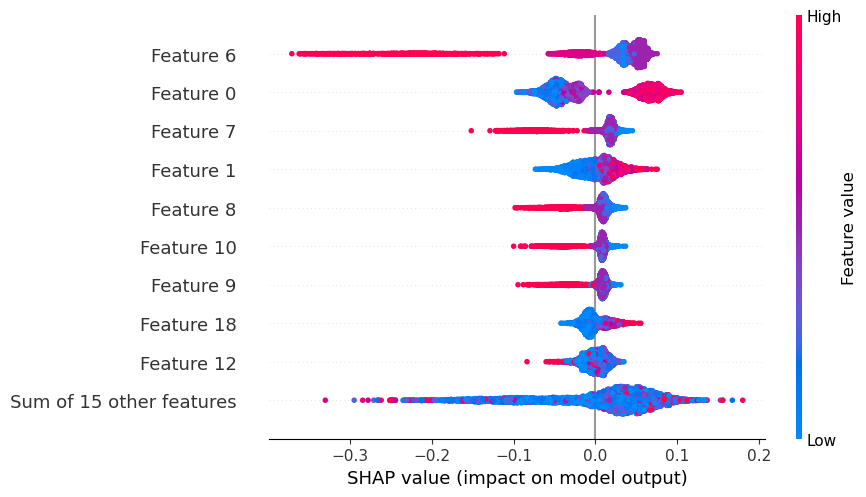

In [21]:
#shap.plots.beeswarm(shap_values_dt[:,:,0],max_display=10)
#shap.plots.beeswarm(shap_values_lr[:,:,0],max_display=10)
shap.plots.beeswarm(shap_values_c_rf[:,:,0],max_display=10)
#shap.plots.beeswarm(shap_values_svm[:,:,0],max_display=10)

<table style="width: 100%;">
  <tr>
      <td style="text-align: left;"><td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>